# Exemplo 7.12 — Controle de velocidade de automóvel (Dorf & Bishop)

### Planta: G(s) = 1 / [(s+2)(s+8)]
### Especificações:
- EP1: erro a degrau = 0 (tipo 1)
- EP2: e_ss(rampa) <= 25%  -> Kv >= 4
- EP3: M.U.P. <= 5%        -> zeta >= 0.69
- EP4: Ts(2%) <= 1.5 s

Controlador: PI = Kp + Ki/s, com Ki/Kp = 2.5 e escolha Kp=26, Ki=65 (como no livro)


In [3]:
!pip install control matplotlib numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.3/578.3 kB 10.9 MB/s eta 0:00:00


In [5]:
# Imports e base

import numpy as np
import matplotlib.pyplot as plt
import control as ctl
from math import acos

plt.rcParams["figure.figsize"] = (7.5, 4.6)
plt.rcParams["axes.grid"] = True
s = ctl.TransferFunction.s


In [6]:
# Planta contínua do veículo (livro):
G = 1/((s+2)*(s+8))
# Requisitos
zeta_min = 0.69
Ts_max   = 1.5
Kv_min   = 4.0

print("G(s) =", G)
print(f"Requisitos: zeta≥{zeta_min}, Ts≤{Ts_max}s, Kv≥{Kv_min}")


G(s) = <TransferFunction>: sys[6]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

         1
  ---------------
  s^2 + 10 s + 16
Requisitos: zeta≥0.69, Ts≤1.5s, Kv≥4.0


In [7]:
Kp = 26.0
Ki = 65.0
Gc = Kp + Ki/s

L = ctl.series(Gc, G)     # malha aberta com o PI
T = ctl.feedback(L, 1)    # malha fechada unitária

Gc, L, T


(TransferFunction(
 array([26., 65.]),
 array([1, 0]),
 outputs=1, inputs=1),
 TransferFunction(
 array([26., 65.]),
 array([ 1, 10, 16,  0]),
 outputs=1, inputs=1),
 TransferFunction(
 array([26., 65.]),
 array([ 1., 10., 42., 65.]),
 outputs=1, inputs=1))

In [12]:
# --- EP2: Kv = lim_{s->0} s*L(s) ---
try:
    L_min = ctl.minreal(s*L, verbose=False)
except Exception:
    L_min = s*L

Kv = ctl.dcgain(L_min)
e_rampa = 1.0 / Kv

# --- Polos de T com fallback para control.matlab ---
try:
    poles = ctl.pole(T)
except AttributeError:
    from control import matlab as ml     # fallback “matlab-like”
    poles = ml.pole(T)

def zeta_wn(p):
    sig = np.real(p)
    wd  = np.imag(p)
    wn  = np.hypot(sig, wd)
    if wn == 0:
        return np.nan, np.nan
    z = -sig / wn
    return z, wn

# pega o primeiro par complexo (dominante); se não houver, deixa NaN
zeta_dom, wn_dom = np.nan, np.nan
for p in np.atleast_1d(poles):
    if np.imag(p) != 0:
        zeta_dom, wn_dom = zeta_wn(p)
        break

# estimativas clássicas de 2ª ordem
Mp_est = (np.exp(-np.pi * zeta_dom / np.sqrt(max(1e-12, 1 - zeta_dom**2)))
          if np.isfinite(zeta_dom) else np.nan)
Ts_est = (4 / (zeta_dom * wn_dom)
          if (np.isfinite(zeta_dom) and wn_dom > 0) else np.nan)

print("Polos(T):", poles)
print(f"Kv = {Kv:.3f}  -> e_rampa = {e_rampa:.3f}")
print(f"zeta_dom ≈ {zeta_dom:.3f}, wn_dom ≈ {wn_dom:.3f} -> "
      f"M.U.P.(est) ≈ {100*Mp_est:.1f}%, Ts(est) ≈ {Ts_est:.3f}s")


Polos(T): [-3.38668206+2.94537008j -3.38668206-2.94537008j -3.22663588+0.j        ]
Kv = 4.062  -> e_rampa = 0.246
zeta_dom ≈ 0.755, wn_dom ≈ 4.488 -> M.U.P.(est) ≈ 2.7%, Ts(est) ≈ 1.181s


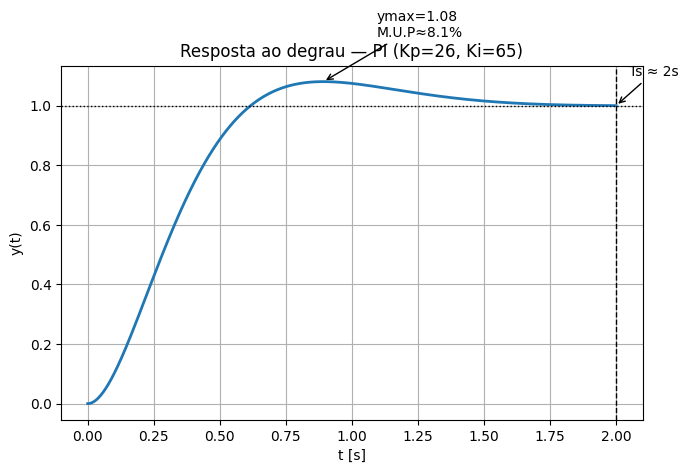

M.U.P.(med) ≈ 8.06%  |  Ts(2%) (med) ≈ 2.000 s


In [14]:
# Resposta ao degrau (métricas medidas)

t, y = ctl.step_response(T, T=np.linspace(0, 2.0, 2000))
yfin = y[-1]
overshoot = (y.max()-yfin)/yfin*100

# Ts(2%) por permanência
win = 0.02*abs(yfin)
Ts = np.nan
for i in range(len(t)-1, -1, -1):
    if np.all(np.abs(y[i:] - yfin) <= win):
        Ts = t[i]; break

fig, ax = plt.subplots()
ax.plot(t, y, lw=2)
ax.axhline(yfin, color='k', ls=':', lw=1)
ax.axvline(Ts, color='k', ls='--', lw=1)
ax.set_title("Resposta ao degrau — PI (Kp=26, Ki=65)")
ax.set_xlabel("t [s]"); ax.set_ylabel("y(t)")
ax.annotate(f"Ts ≈ {Ts:.3g}s", xy=(Ts,yfin), xytext=(Ts+0.05, yfin+0.1),
            arrowprops=dict(arrowstyle="->"))
ax.annotate(f"ymax={y.max():.3g}\nM.U.P≈{overshoot:.1f}%",
            xy=(t[np.argmax(y)], y.max()),
            xytext=(t[np.argmax(y)]+0.2, y.max()+0.15),
            arrowprops=dict(arrowstyle="->"))
plt.show()

print(f"M.U.P.(med) ≈ {overshoot:.2f}%  |  Ts(2%) (med) ≈ {Ts:.3f} s")


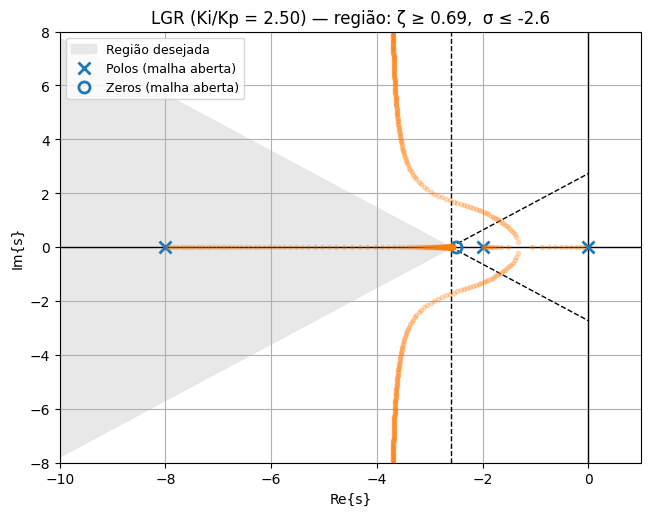

In [17]:
# --- LGR com região desejada (≈ Fig. 7.50) — versão robusta para Colab ---

import numpy as np
import matplotlib.pyplot as plt
from math import acos

# parâmetros do livro
theta = np.degrees(acos(zeta_min))   # ângulo do cone (zeta_min definido antes)
sigma_line = -2.6                    # linha vertical

alpha = Ki / Kp                      # mantém Ki/Kp fixo

def L_with_ratio(Kp_val):
    Ki_val = alpha * Kp_val
    return (Kp_val + Ki_val/s) * G   # L(s) = Gc(s)G(s)

# -- helpers com fallback matlab-like --
def poles_of(sys):
    try:
        return ctl.pole(sys)
    except AttributeError:
        from control import matlab as ml
        return ml.pole(sys)

def zeros_of(sys):
    try:
        return ctl.zero(sys)
    except AttributeError:
        from control import matlab as ml
        return ml.zero(sys)

# trajetórias para vários Kp (root-locus paramétrico mantendo Ki/Kp)
Kps = np.linspace(0, 120, 250)
traj = []
for Kpi in Kps:
    Ti = ctl.feedback(L_with_ratio(Kpi), 1)
    traj.append(np.asarray(poles_of(Ti)))

# figura
fig, ax = plt.subplots(figsize=(7.5, 5.6))
ax.axvline(0, color='k', lw=1)
ax.axhline(0, color='k', lw=1)

# região desejada (cone + linha σ = -2.6)
x = np.linspace(-10, sigma_line, 200)
upper = np.tan(np.radians(theta)) * (x - sigma_line)
ax.fill_between(x, upper, -upper, color='0.9', alpha=0.9, label='Região desejada')
ax.plot([sigma_line, 0], [0,  np.tan(np.radians(theta))*(0 - sigma_line)], 'k--', lw=1)
ax.plot([sigma_line, 0], [0, -np.tan(np.radians(theta))*(0 - sigma_line)], 'k--', lw=1)
ax.axvline(sigma_line, color='k', ls='--', lw=1)

# polos/zeros da malha ABERTA com o PI escolhido (Kp, Ki definidos antes)
H_open = (Kp + Ki/s) * G
P = np.asarray(poles_of(H_open))
Z = np.asarray(zeros_of(H_open))

# desenho manual de polos (x) e zeros (o) para evitar pzmap
if P.size:
    ax.plot(np.real(P), np.imag(P), 'x', ms=9, mew=2, label='Polos (malha aberta)')
if Z.size:
    ax.plot(np.real(Z), np.imag(Z), 'o', ms=8, mfc='none', mec='C0', mew=2, label='Zeros (malha aberta)')

# root-locus “paramétrico”: pontos dos polos de T para vários Kp
for poles_T in traj:
    ax.plot(np.real(poles_T), np.imag(poles_T), '.', color='C1', alpha=0.25)

ax.set_xlim(-10, 1)
ax.set_ylim(-8, 8)
ax.set_xlabel("Re{s}")
ax.set_ylabel("Im{s}")
ax.set_title(f"LGR (Ki/Kp = {alpha:.2f}) — região: ζ ≥ {zeta_min},  σ ≤ {sigma_line}")
ax.legend(loc='upper left', fontsize=9)
plt.show()


In [18]:
# Estabilidade por Routh (cúbico resultante)

def routh_cubic(a3,a2,a1,a0):
    if abs(a3-1) > 1e-12:
        a2/=a3; a1/=a3; a0/=a3
    b1 = (a2*a1 - a0)/a2
    return [1, a2, b1, a0]

num, den = ctl.tfdata(T)
den = np.squeeze(den)  # [a3,a2,a1,a0]
first_col = routh_cubic(*den)
print("Den(T):", den)
print("Routh 1ª coluna:", first_col, "-> estável se todos > 0")


Den(T): [ 1 10 42 65]
Routh 1ª coluna: [1, np.int64(10), np.float64(35.5), np.int64(65)] -> estável se todos > 0
